## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one


In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline

## import data
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [2]:
## Loading data
df = pd.read_csv("course_lead_scoring.csv")

print("## checking the dtypes ##")
print(df.dtypes)
print("## checking the number of total NAs ##")
print(df.isna().sum())


## checking the dtypes ##
lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object
## checking the number of total NAs ##
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


In [3]:
print(df.head())

    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  


In [4]:
# impute the missing values
for feature in df.columns:
    # impute numerical features
    if df[feature].dtype == 'int64':
        df[feature] = df[feature].fillna(0)
    elif df[feature].dtype == 'float64':
        df[feature] = df[feature].fillna(0.0)
    # impute categorical features
    elif df[feature].dtype == 'object':
        df[feature] = df[feature].fillna('NA')
        
### checking for missing values
print(df.isna().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [5]:
## data splitting
from sklearn.model_selection import train_test_split
# random state
n = 1
target = 'converted'

# First Split: Train (60%) vs. Temporary (40%) followed by Second Split: Test (50%) and Val (50%)
df_full_train, df_test = train_test_split(df, test_size=0.4, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.5, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Separate features (X) and target (y) for each set
y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

df_train = df_train.drop(columns=[target])
df_val = df_val.drop(columns=[target])
df_test = df_test.drop(columns=[target])

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`


In [6]:
numerical = df.drop(columns=[target]).select_dtypes(include='number').columns.tolist()
categorical = df.drop(columns=[target]).select_dtypes(include='object').columns.tolist()

In [7]:
#@ CALCULATING ROC AUC SCORE:
from sklearn.metrics import roc_auc_score
results = {}

for feature in numerical:

    auc = roc_auc_score(y_train, df_train[feature])   
    if auc < 0.5 :        
        adjusted_auc = roc_auc_score(ground_truth, - y_score)
        results[feature] = {
            'auc_score': round(adjusted_auc,3)
            }
    else:
        results[feature] = {
           'auc_score': round(auc,3)
            }

auc_scores = pd.DataFrame(results).T.sort_values('auc_score',ascending = False)

print(auc_scores)
        

                          auc_score
interaction_count             0.751
number_of_courses_viewed      0.748
lead_score                    0.611
annual_income                 0.538




### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


In [8]:
#@ TRAINING LOGISTIC REGRESSION MODEL:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

columns = categorical + numerical

# Initialize the vectorizer
dv = DictVectorizer(sparse=False)

# Fit and transform the X_train and X_val
train_dicts = df_train[columns].to_dict('records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[columns].to_dict('records')
X_val = dv.transform(val_dicts)

# Initialize the classifier
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Get probability predictions on the validation set
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Compute the ROC AUC score
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"AUC on Validation Dataset: {round(auc_score, 3)}")


AUC on Validation Dataset: 0.825


In [9]:
#@ INSPECTING THE ROC AUC SCORE:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.7209828324286155

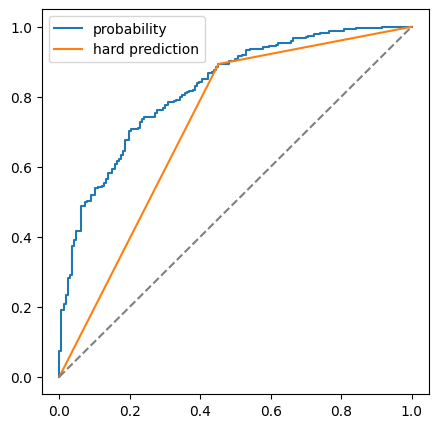

In [10]:

#@ INSPECTING THE ROC CURVE:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()
     



### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745



### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


In [11]:
from sklearn.metrics import precision_score, recall_score

# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

# Compute F1 for each threshold
scores = []
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    
    p = precision_score(y_val, y_pred, zero_division=0)
    r = recall_score(y_val, y_pred, zero_division=0)
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    diff = np.abs(p-r)
    scores.append((t, p, r, f1))

df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1'])


# Find the threshold with the maximal F1 score
max_f1_row = df_scores.loc[df_scores['f1'].idxmax()]

max_f1_threshold = max_f1_row['threshold']
max_f1_score = max_f1_row['f1']

print(f"Maximal F1 score ({max_f1_score:.4f}) is achieved at threshold: {max_f1_threshold:.2f}")

Maximal F1 score (0.8245) is achieved at threshold: 0.43


Text(0, 0.5, 'Score')

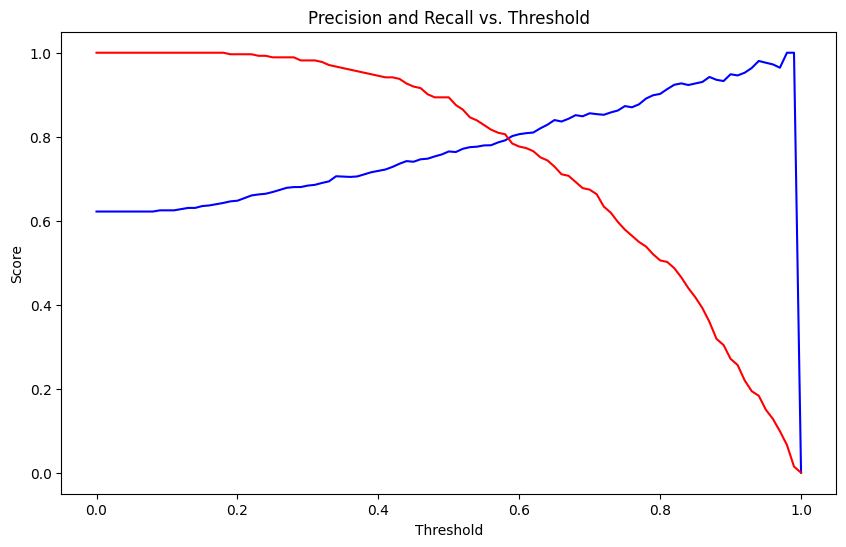

In [12]:
#@ INSPECTING THE CURVES:
plt.figure(figsize=(10, 6))
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision', color='blue')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall', color='red')

plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')

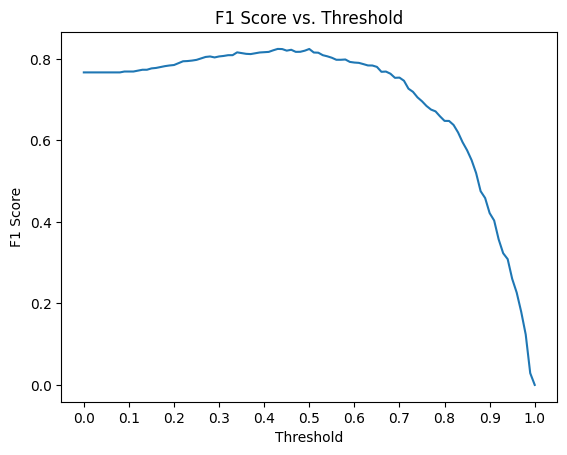

In [13]:
#@ INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))

plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36


In [14]:
# First Split: Train (60%) vs. Temporary (40%) followed by Second Split: Test (50%) and Val (50%)
df_full_train, df_test = train_test_split(df, test_size=0.4, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.5, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#@ DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

#@ INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['converted']
    y_val = df_val['converted']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.828 +- 0.010



### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [15]:
#@ INSPECTING KFOLD CROSS VALIDATION:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted
        y_val = df_val.converted

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.828 +- 0.010
C=0.001, 0.828 +- 0.010
C=   1, 0.828 +- 0.010
